In [1]:
# 지갑주소를 불러오기 위한 코드 생성 작업
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import requests
import json

## TODO
1. 누적 PnL code
2. 현재 시점의 PnL code

## needs
1. 지갑정보를 통하여 현재 구매중인 데이터를 가지고 오는 코드
2. 지갑 정보를 통해 과거 데이터를 불러오는 코드
3. @문자가 들어가 있는 fetch코드를 통해 변환하는 함수

In [17]:
import requests
import json
import pandas as pd

class CoinNamePreprocessing:
    def __init__(self, wallet_address):
        self.wallet_address = wallet_address

    def fetch_spot_meta(self):
        """Tname : coin name을 1:1로 매칭시키는 함수"""

        api_url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}
        payload = {"type": 'spotMetaAndAssetCtxs'}

        response = requests.post(api_url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()

        data = response.json()

        tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
        universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})

        tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
        return tokens

    def fetch_historical_orders(self):
        """Hyperliquid에서 사용자의 과거 주문 내역을 가져와 DataFrame으로 변환"""
        url_orders = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}

        # 요청 바디 설정
        body_orders = {
            "type": "historicalOrders",
            "user": self.wallet_address  # 지갑 주소
        }

        # API 요청
        response = requests.post(url_orders, headers=headers, json=body_orders)

        if response.status_code == 200:
            data = response.json()

            # 주문 데이터가 존재하지 않으면 빈 DataFrame 반환
            if not data or not isinstance(data, list):
                print("❌ 주문 데이터 없음.")
                return pd.DataFrame()

            # 필요한 데이터만 추출
            orders_list = []
            for item in data:
                order = item.get("order", {})  # order 키 안에 있는 데이터 가져오기
                orders_list.append({
                    "Coin": order.get("coin"),
                    "Side": order.get("side"),
                    "Limit Price": float(order.get("limitPx", 0)),
                    "Size": float(order.get("sz", 0)),
                    "Order ID": order.get("oid"),
                    "Timestamp": pd.to_datetime(order.get("timestamp"), unit="ms"),  # 시간 변환
                    "Trigger Condition": order.get("triggerCondition"),
                    "Is Trigger": order.get("isTrigger"),
                    "Trigger Price": float(order.get("triggerPx", 0)),
                    "Order Type": order.get("orderType"),
                    "Original Size": float(order.get("origSz", 0)),
                    "Reduce Only": order.get("reduceOnly")
                })

            # DataFrame 변환
            df_orders = pd.DataFrame(orders_list)
            df_orders = df_orders[df_orders["Size"]>0]
            
            # Side 열 이름을 변경하기
            df_orders["Side"] = df_orders["Side"].map({"A": "Sell", "B": "Buy"})
            df_orders.sort_values("Timestamp", inplace=True)
            
            # 현재 현물 정보만 가지고 평가한다
            filtered_df = df_orders[df_orders["Coin"].str.startswith("@")].copy()

            return filtered_df

        else:
            print(f"API 요청 실패: {response.status_code} - {response.text}")
            return pd.DataFrame()

    def match_coin(self, df):
        """지갑 보유 코인을 spot_meta 정보와 매칭하고, Coin 값을 Tname으로 변환"""
        spot_meta = self.fetch_spot_meta()
        spot_meta1 = spot_meta[["Tname", "coin"]]  # Tname과 coin 매칭 정보

        # Coin → Tname 매핑 딕셔너리 생성
        coin_to_tname = dict(zip(spot_meta1["coin"], spot_meta1["Tname"]))

        # Coin` 열을 `Tname` 값으로 변환
        df["Coin"] = df["Coin"].map(coin_to_tname)

        # 변환된 값들 중, spot_meta1에 존재하는 Tname 값만 필터링
        matched_rows = df[df["Coin"].isin(spot_meta1["Tname"].values)]
        matched_rows["Date"] = matched_rows["Timestamp"].dt.date

        return matched_rows
####################################################################################################  
# 실행 예제
wallet_address = "0x157a44B0555B31A0642fd0aF47f6806D3b86Ec9f"
coin_processor = CoinNamePreprocessing(wallet_address)

# 지갑 정보에 대한 주문내역 가져오기
df_orders = coin_processor.fetch_historical_orders()

# 1:1 매칭
spot_matching_data = coin_processor.match_coin(df_orders)

In [18]:
from collections import deque

def calculate_pnl_fifo(df_orders):
        """FIFO(선입선출) 방식으로 PnL 계산"""
        pnl_list = []  # 최종 PnL 데이터 저장
        inventory = {}  # 코인별 보유 상태 (FIFO 큐 사용)

        # 날짜순 정렬
        df_orders = df_orders.sort_values("Date")

        for index, row in df_orders.iterrows():
            coin, side, price, size, date = row["Coin"], row["Side"], row["Limit Price"], row["Size"], row["Date"]

            if coin not in inventory:
                inventory[coin] = deque()  # 각 코인별 FIFO 큐 생성

            if side == "Buy":
                # 매수 시: 큐에 (매입가, 개수) 저장
                inventory[coin].append((price, size))

            elif side == "Sell":
                # 매도 시: FIFO 방식으로 매입분 매칭하여 PnL 계산
                remaining_size = size  # 매도할 개수
                total_cost = 0
                total_sell_value = price * size  # 매도 총 수익

                while remaining_size > 0 and inventory[coin]:
                    buy_price, buy_size = inventory[coin].popleft()

                    if buy_size <= remaining_size:
                        # 현재 보유분을 전부 매도
                        pnl = (price - buy_price) * buy_size
                        total_cost += buy_price * buy_size
                        remaining_size -= buy_size
                    else:
                        # 일부만 매도 후 남은 개수 다시 큐에 저장
                        pnl = (price - buy_price) * remaining_size
                        total_cost += buy_price * remaining_size
                        inventory[coin].appendleft((buy_price, buy_size - remaining_size))
                        remaining_size = 0

                    # 결과 저장
                    pnl_list.append({"Date": date, "Coin": coin, "PnL": pnl, "Sell Price": price, "Buy Cost": total_cost, "Sell Size": size})

        # 결과를 DataFrame으로 변환
        pnl_df = pd.DataFrame(pnl_list)
        
        return pnl_df

In [19]:
sample = calculate_pnl_fifo(spot_matching_data)

In [22]:
# 🔹 일별 PnL 집계
df_pnl_daily = sample.groupby("Date")["PnL"].sum().reset_index()

# 🔹 누적 PnL 계산
df_pnl_daily["Cumulative PnL"] = df_pnl_daily["PnL"].cumsum()

In [23]:
df_pnl_daily

,Date,PnL,Cumulative PnL
0,2025-01-12,-431.691655,-431.691655
1,2025-02-12,-6.332634,-438.024289
2,2025-02-13,-351.588020,-789.612309
3,2025-02-14,1327.244450,537.632141
4,2025-02-15,4561.695810,5099.327951


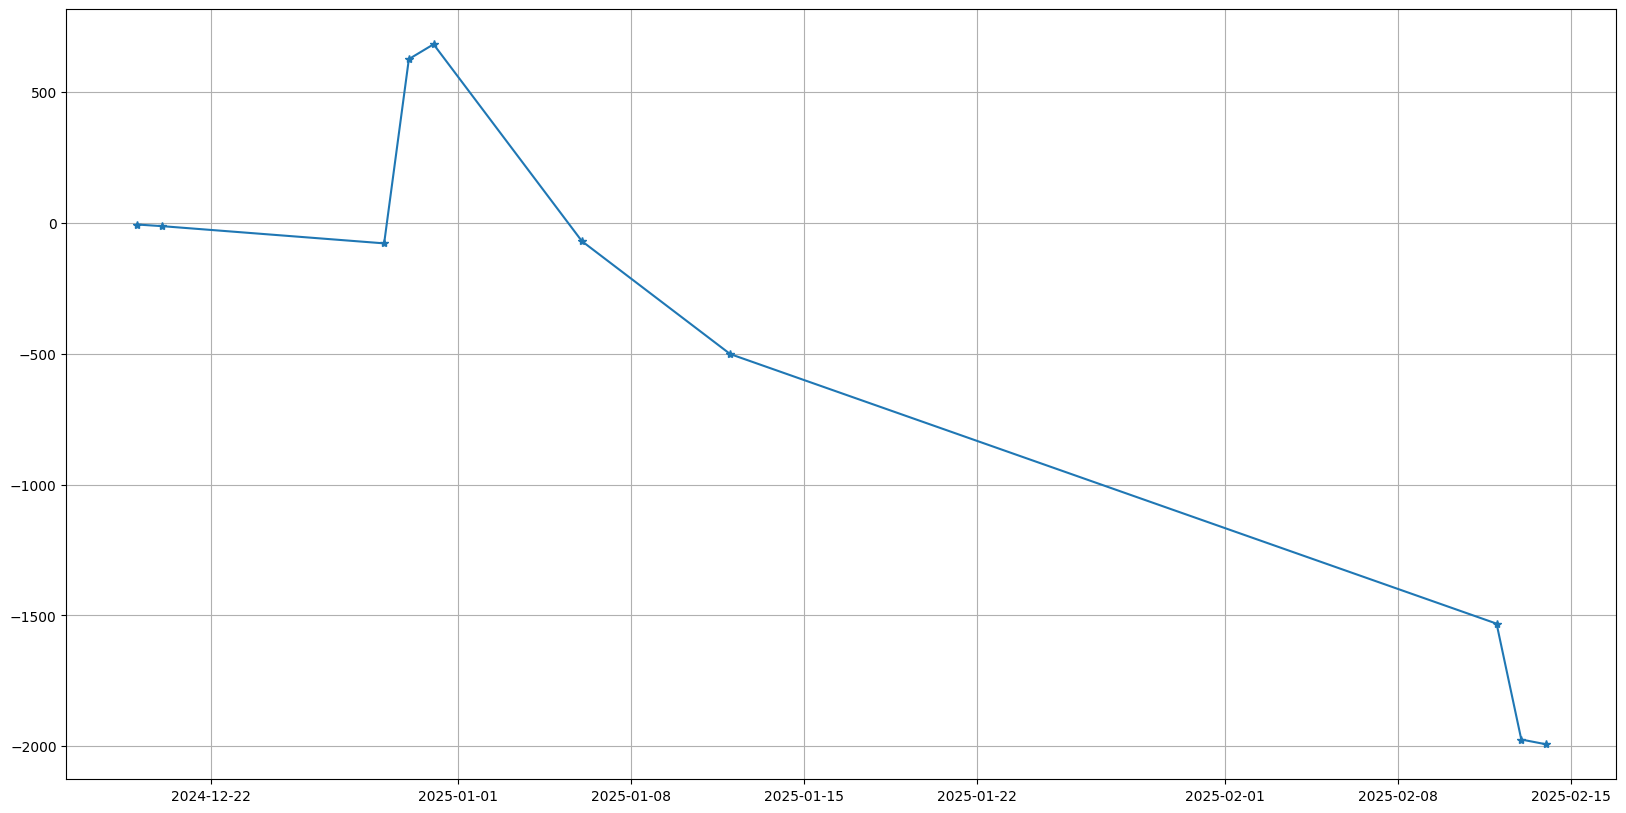

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df_pnl_daily["Date"], df_pnl_daily["Cumulative PnL"], "*-")
plt.grid()